Practica Lunes 23/04

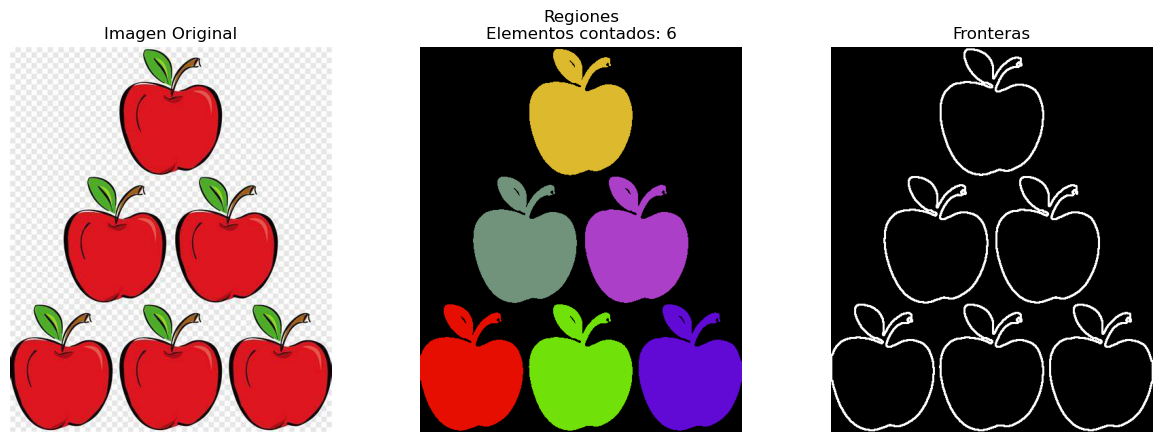

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

def contar(binaria, area_minima=500):
    etiquetas = measure.label(binaria, connectivity=2)
    regiones = measure.regionprops(etiquetas)
    return len([r for r in regiones if r.area >= area_minima])

imagen = cv2.imread('manzana.jpg')

gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
_, binarized = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contarr = contar(binarized)

cant, region = cv2.connectedComponents(binarized)
colores = np.random.randint(0, 255, size=(cant, 3), dtype=np.uint8)
colores[0] = [0, 0, 0]
region_coloreada = colores[region]

contorno, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lines = cv2.drawContours(np.zeros_like(gray), contorno, -1, 255, 2)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(132)
plt.title(f'Regiones\nElementos contados: {contarr}')
plt.imshow(region_coloreada)
plt.axis('off')

plt.subplot(133)
plt.title('Fronteras')
plt.imshow(lines, cmap='gray')
plt.axis('off')

plt.show()


PRACTICA DE LABORATORIO

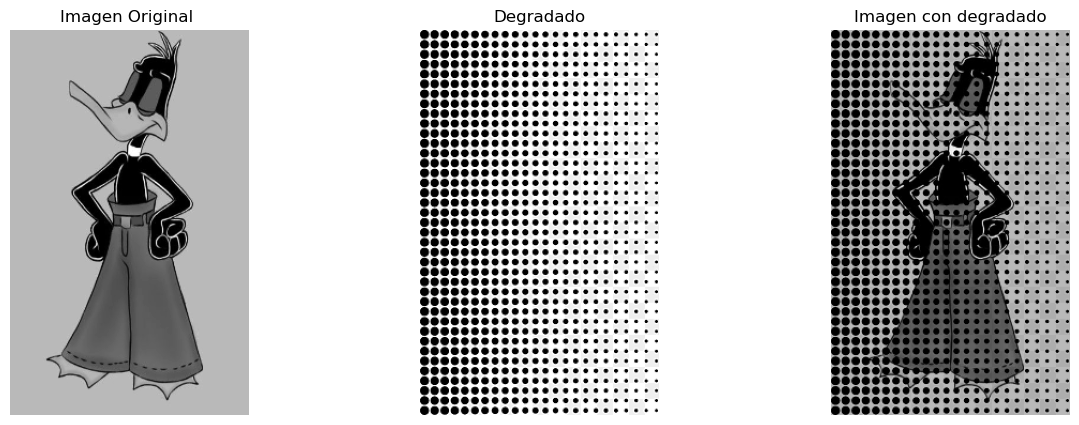

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagen = cv2.imread('pato.jpg')
degradado = cv2.imread('puntos.png')

imagen = cv2.resize(imagen, (degradado.shape[1], degradado.shape[0]))
imagen_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
degradado_gray = cv2.cvtColor(degradado, cv2.COLOR_BGR2GRAY)

degradado_norm = degradado_gray / 255.0
resultado = (imagen_gray * degradado_norm).astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Imagen Original ')
plt.imshow(imagen_gray, cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Degradado')
plt.imshow(degradado_gray, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Imagen con degradado')
plt.imshow(resultado, cmap='gray')
plt.axis('off')

plt.show()


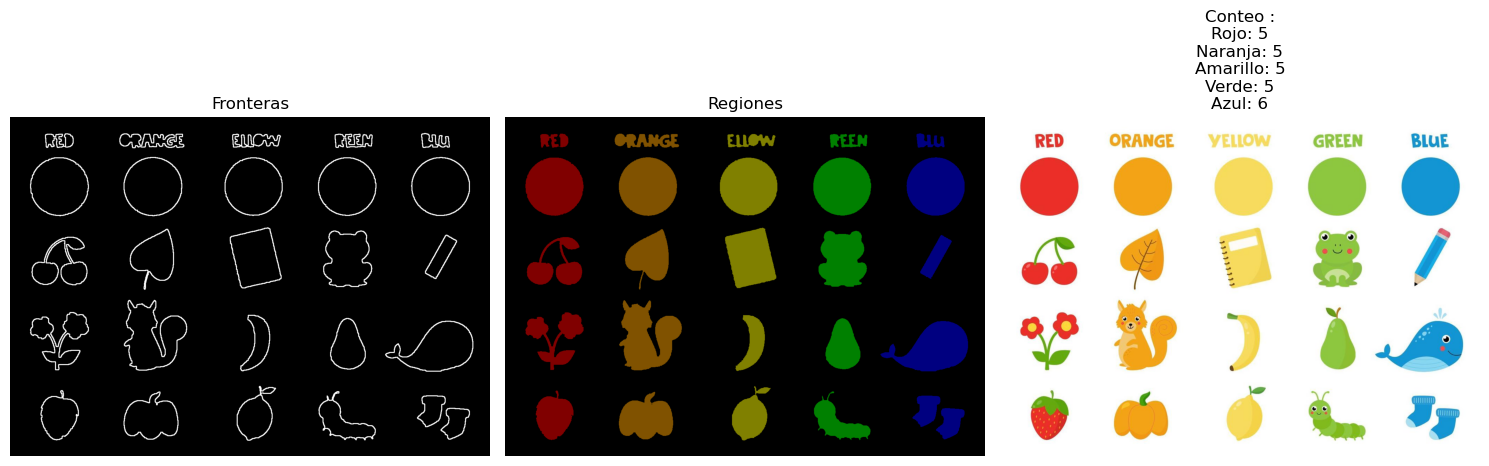

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

imagen = cv2.imread('colores.jpg')
hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

rangos_colores = {
    'rojo':    ((np.array([0, 100, 100]), np.array([10, 255, 255])), (0, 0, 255)),
    'naranja': ((np.array([11, 100, 100]), np.array([20, 255, 255])), (0, 165, 255)),
    'amarillo':((np.array([21, 100, 100]), np.array([30, 255, 255])), (0, 255, 255)),
    'verde':   ((np.array([35, 100, 100]), np.array([85, 255, 255])), (0, 255, 0)),
    'azul':    ((np.array([86, 100, 100]), np.array([125, 255, 255])), (255, 0, 0)),
}

mascara_global = np.zeros(hsv.shape[:2], dtype=np.uint8)
mascaras_individuales = {}

for nombre, (rango, _) in rangos_colores.items():
    mascara = cv2.inRange(hsv, rango[0], rango[1])
    kernel = np.ones((5, 5), np.uint8)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel)
    mascara_global = cv2.bitwise_or(mascara_global, mascara)
    mascaras_individuales[nombre] = mascara

contornos, _ = cv2.findContours(mascara_global, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

imagen_contornos = np.zeros_like(imagen)
imagen_coloreada = np.zeros_like(imagen)
conteo_colores = Counter()

for contorno in contornos:
    area = cv2.contourArea(contorno)
    if area < 800:
        continue

    mask_objeto = np.zeros(hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask_objeto, [contorno], -1, 255, -1)

    pixeles_por_color = {}
    for nombre, mascara_color in mascaras_individuales.items():
        interseccion = cv2.bitwise_and(mascara_color, mask_objeto)
        pixeles_por_color[nombre] = cv2.countNonZero(interseccion)

    color_predominante = max(pixeles_por_color, key=pixeles_por_color.get)
    conteo_colores[color_predominante] += 1

    color_bgr = rangos_colores[color_predominante][1]
    cv2.drawContours(imagen_contornos, [contorno], -1, (255, 255, 255), 2)
    imagen_coloreada[mask_objeto == 255] = cv2.addWeighted(
        imagen_coloreada[mask_objeto == 255], 0.5,
        np.full_like(imagen_coloreada[mask_objeto == 255], color_bgr), 0.5, 0
    )

titulo = "\n".join([f"{color.capitalize()}: {conteo_colores[color]}" for color in rangos_colores])

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(cv2.cvtColor(imagen_contornos, cv2.COLOR_BGR2RGB))
plt.title("Fronteras")
plt.axis("off")

plt.subplot(132)
plt.imshow(cv2.cvtColor(imagen_coloreada, cv2.COLOR_BGR2RGB))
plt.title("Regiones")
plt.axis("off")

plt.subplot(133)
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title(f"Conteo :\n{titulo}")
plt.axis("off")

plt.tight_layout()
plt.show()


Aplicacion de deteccion de bordes canny

Lo primero que debemos de hacer es aplicar un filtro gaussiano para elimar el ruido, el ruido un poco mas fuerte, luego
usamos un medianBlur para tener un filtro adicional desasernos del ruido como los pixeles o puntos donde todavia quedo ruido,
ahora aplicamo el operador canny, le colocoamos un umbral de deteccion entre 50 y 150, este sera la sensibilidad con la que se detectan
los bordes, y una vez hecho esto nos muestra el borde de la cara.



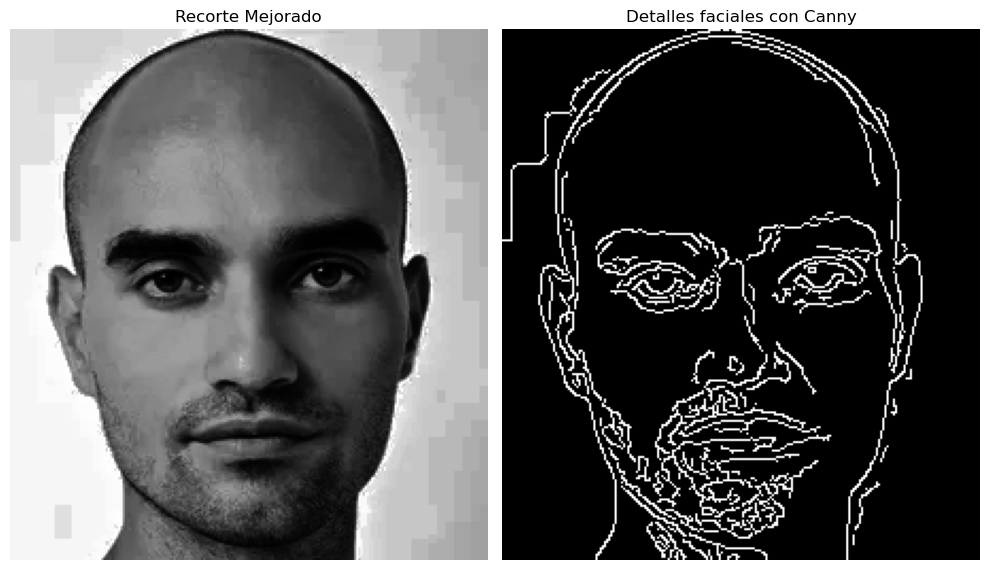

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagen = cv2.imread('hombre.jpg', cv2.IMREAD_GRAYSCALE)

x_inicio, x_fin = 275, 500
y_inicio, y_fin = 0, 250
imagen_recortada = imagen[y_inicio:y_fin, x_inicio:x_fin]

# Mejorar contraste para resaltar detalles faciales
imagen_ecualizada = cv2.equalizeHist(imagen_recortada)

# Menor suavizado para conservar detalles
imagen_suavizada = cv2.GaussianBlur(imagen_ecualizada, (3, 3), 0)

# Umbrales más sensibles para detectar más bordes
umbral_bajo = 30
umbral_alto = 100
bordes = cv2.Canny(imagen_suavizada, umbral_bajo, umbral_alto)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.title("Recorte Mejorado")
plt.imshow(imagen_ecualizada, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Detalles faciales con Canny")
plt.imshow(bordes, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
